In [70]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import numba
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from metrics import concordance_td

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
from torch import nn
import torch.nn.functional as F
import torchtuples as tt # Some useful functions

from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from torch import Tensor

import seaborn as sn
sn.set_theme(style="white", palette="rocket_r")

import random

seed = 100 #(1024, 85858, 3673, 32)

random.seed(seed)
np.random.seed(seed)
_ = torch.manual_seed(seed)

In [2]:
# Process the time-series
def timeseries_processing(timeseries, labels, hour):
    timeseries.reset_index(level=1, inplace=True)
    timeseries.time = pd.to_timedelta(timeseries.time, errors='coerce')
    
    # Convert the time-stamps into hours
    timeseries.time = timeseries.time.astype(int)/(1000000000*24)
        
    # Add time of event
    timeseries = timeseries.merge(labels, left_index=True, right_index=True)
    
    # Only keep those timestamps with more than time before the event for prediction
    timeseries = timeseries[timeseries['time'] <= (timeseries['actualiculos'] - hour)]
    
    # Drop the labels column, we will add them at the end for consistency and to avoid redundancy
    timeseries = timeseries.drop(columns=['actualiculos', 'actualhospitalmortality', 'uniquepid', 'patienthealthsystemstayid'])
    
    timeseries.reset_index(inplace=True)
    timeseries.set_index(['patient', 'time'], inplace=True)
    
    return timeseries

In [4]:
cd ..

/Users/mmesinovic/Desktop/AMI/Data/MIMICIV_data


In [5]:
# Load the static features
labels = pd.read_csv('preprocessed_labels.csv', index_col='patient')
labels['actualiculos'] = labels['actualiculos']*24
labels.drop(labels.loc[labels['actualiculos']>240].index, inplace=True)

In [6]:
# Load the time-series data
timeseries = pd.read_csv('preprocessed_timeseries.csv', index_col=['patient', 'time'])
# Only take values up to 24 hours before event
timeseries_summary = timeseries_processing(timeseries, labels, 24)

In [7]:
# Time shift so that the starting point for each sample is time = 0
timeseries_summary.reset_index(level=1, inplace=True)
minimum_shifts = timeseries_summary.time.min(level=0)
timeseries_summary = timeseries_summary.merge(minimum_shifts, left_index=True, right_index=True)
timeseries_summary['time'] = timeseries_summary['time_x'] - timeseries_summary['time_y']
timeseries_summary.drop(columns=['time_x', 'time_y'], inplace=True)
timeseries_summary.set_index(['time'], append=True, inplace=True)

/var/folders/rb/zrr_wqjs59v2n19lg6kssgnw0000gr/T/ipykernel_62103/204231096.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  minimum_shifts = timeseries_summary.time.min(level=0)


In [8]:
# Forward (for measurements up until time-to-event) and backward (when the first couple of measurements are missing) fill
timeseries_summary.update(timeseries_summary.groupby(level=0).ffill())
timeseries_summary.update(timeseries_summary.groupby(level=0).bfill())

timeseries_summary.ffill(axis = 0, inplace=True)
timeseries_summary.bfill(axis = 0, inplace=True)

In [9]:
# Import static features
statics = pd.read_csv('preprocessed_flat.csv', index_col='patient')
statics.drop('nullheight', axis=1, inplace=True)
timeseries_summary = timeseries_summary.merge(statics, left_index=True, right_index=True)

In [10]:
sample_labels = labels.loc[list(set(list(timeseries_summary.index.get_level_values('patient'))))]

# Create validation and test set (20% each)
df_test = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_test.index)
df_val = sample_labels.sample(frac=0.2)
df_train = sample_labels.drop(df_val.index)

st = set(list(df_val.index.get_level_values('patient')))
val_index = [i for i, e in enumerate(list(set(list(timeseries_summary.index.get_level_values('patient'))))) if e in st]
st = set(list(df_train.index.get_level_values('patient')))
train_index = [i for i, e in enumerate(list(set(list(timeseries_summary.index.get_level_values('patient'))))) if e in st]
st = set(list(df_test.index.get_level_values('patient')))
test_index = [i for i, e in enumerate(list(set(list(timeseries_summary.index.get_level_values('patient'))))) if e in st]

# Extract time-to-event and event label
num_durations = 10
labtrans = LogisticHazard.label_transform(num_durations)
get_target = lambda df: (df['actualiculos'].values, df['actualhospitalmortality'].values)
y_train_surv = labtrans.fit_transform(*get_target(df_train))
y_val_surv = labtrans.transform(*get_target(df_val))

In [11]:
# create time-series input for LSTM of shape [n, timestep, features]
def split_sequence(dataframe, n_steps):
    lstm_input = np.empty((len(dataframe.index.levels[0]), n_steps, 98)) #98, 65
    lstm_input[:] = np.nan
    for i in range(len(dataframe.index.levels[0])):
        sample = dataframe.loc[dataframe.index.levels[0][i].tolist()]
        sequence = sample.to_numpy()
        n_features = sequence.shape[1]
        time_length = sequence.shape[0]

        if n_steps > time_length:
            a = np.empty((n_steps-time_length,n_features))
            for j in range((n_steps-time_length)):
                a[j, :] = sequence[0, :]
            sequence = np.vstack((a,sequence))
        sequence = sequence[-n_steps:, :]
        lstm_input[i, :, :] = sequence
    
    return lstm_input

In [12]:
# Extract data into LSTM timeseries format with 72 1-hour timesteps
timeseries_lstm_input = split_sequence(timeseries_summary, 72)

In [13]:
timeseries_lstm_input_train = timeseries_lstm_input[train_index, :, :]
timeseries_lstm_input_val = timeseries_lstm_input[val_index, :, :]
timeseries_lstm_input_test = timeseries_lstm_input[test_index, :, :]

# Quantile transform the features across the population for each timestep
scalers = {}
for i in range(timeseries_lstm_input_train.shape[1]):
    scalers[i] = QuantileTransformer(random_state=0)
    timeseries_lstm_input_train[:, i, :] = scalers[i].fit_transform(timeseries_lstm_input_train[:, i, :]) 
    
for i in range(timeseries_lstm_input_val.shape[1]):
    timeseries_lstm_input_val[:, i, :] = scalers[i].transform(timeseries_lstm_input_val[:, i, :]) 

for i in range(timeseries_lstm_input_test.shape[1]):
    timeseries_lstm_input_test[:, i, :] = scalers[i].transform(timeseries_lstm_input_test[:, i, :]) 

x_train = timeseries_lstm_input_train.astype('float32')
x_val = timeseries_lstm_input_val.astype('float32')
x_test = timeseries_lstm_input_test.astype('float32')

train_target = np.zeros((x_train.shape[0], x_train.shape[1], 1))
train_target[:, :, -1] = y_train_surv[0].reshape(-1, 1)
x_train = np.append(x_train, train_target, axis=2)

val_target = np.zeros((x_val.shape[0], x_val.shape[1], 1))
val_target[:, :, -1] = y_val_surv[0].reshape(-1, 1)
x_val = np.append(x_val, val_target, axis=2)

train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [14]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        if tensor.dim() == 2:
            return tensor[:, :]
        return tensor[:, -1, :]

In [15]:
class Decoder(nn.Module):
    def __init__(self, seq_len, no_features, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.no_features = no_features
        self.hidden_size = (2 * no_features)
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )
        self.dropout = nn.Dropout()

        self.fc1 = nn.Linear(self.hidden_size, 3*self.hidden_size)
        self.fc2 = nn.Linear(3*self.hidden_size, 5*self.hidden_size)
        self.fc3 = nn.Linear(5*self.hidden_size, 3*self.hidden_size)
        self.fc4 = nn.Linear(3*self.hidden_size, output_size)
        
    def forward(self, x, y):
        x = torch.cat((x, y.reshape(-1, 1)), dim=1)
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1, self.seq_len, self.hidden_size))
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.dropout(self.fc3(x))
        out = self.fc4(x)
        return out

In [16]:
class DySurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()
        
        self.lstm1 = nn.LSTM(in_features, in_features, batch_first=True)
        self.extract = extract_tensor()
        self.fc11 = nn.Linear(in_features, 3*in_features)
        self.fc12 = nn.Linear(3*in_features, 5*in_features)
        self.fc13 = nn.Linear(5*in_features, 3*in_features)
        self.fc14 = nn.Linear(3*in_features, encoded_features)

        self.fc24 = nn.Linear(3*in_features, encoded_features)
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout()

        self.surv_net = nn.Sequential(
            nn.Linear(encoded_features, 3*in_features), nn.ReLU(),
            nn.Linear(3*in_features, 5*in_features), nn.ReLU(),
            nn.Linear(5*in_features, 3*in_features), nn.ReLU(),
            nn.Linear(3*in_features, out_features),
        )
        
        self.decoder2 = Decoder(72, encoded_features+1, in_features)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        sample_z = eps.mul(std).add_(mu)

        return sample_z
    
    def encoder(self, x):
        x = self.lstm1(x)
        x = self.relu(self.fc11(self.extract(x)))
        x = self.relu(self.fc12(x))
        x = self.relu(self.fc13(x))
        mu_z = self.fc14(x)
        logvar_z = self.fc24(x)

        return mu_z, logvar_z
    
    def forward(self, input):
        y = input[:, -1, 98]
        x = input[:, :, :98]
        mu, logvar = self.encoder(x.float())
        z = self.reparameterize(mu, logvar)
        
        return self.decoder2(z, y.float()), self.surv_net(z), mu, logvar

    def predict(self, input):
        mu, logvar = self.encoder(input)
        encoded = self.reparameterize(mu, logvar)
        return self.surv_net(encoded)

In [17]:
in_features = x_train.shape[2]-1
encoded_features = 20 # use 20 latent factors
out_features = labtrans.out_features # how many discrete time points to predict for (10 here)
net = DySurv(in_features, encoded_features, out_features)

In [18]:
class _Loss(torch.nn.Module):
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

In [34]:
def _reduction(loss: Tensor, reduction: str = 'mean') -> Tensor:
    if reduction == 'none':
        return loss
    elif reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    raise ValueError(f"`reduction` = {reduction} is not valid. Use 'none', 'mean' or 'sum'.")

In [35]:
def nll_logistic_hazard(phi: Tensor, idx_durations: Tensor, events: Tensor,
                        reduction: str = 'mean') -> Tensor:
    """
    References:
    [1] Håvard Kvamme and Ørnulf Borgan. Continuous and Discrete-Time Survival Prediction
        with Neural Networks. arXiv preprint arXiv:1910.06724, 2019.
        https://arxiv.org/pdf/1910.06724.pdf
    """
    if phi.shape[1] <= idx_durations.max():
        raise ValueError(f"Network output `phi` is too small for `idx_durations`."+
                         f" Need at least `phi.shape[1] = {idx_durations.max().item()+1}`,"+
                         f" but got `phi.shape[1] = {phi.shape[1]}`")
    if events.dtype is torch.bool:
        events = events.float()
    events = events.view(-1, 1)
    idx_durations = idx_durations.view(-1, 1)
    y_bce = torch.zeros_like(phi).scatter(1, idx_durations, events)
    bce = F.binary_cross_entropy_with_logits(phi, y_bce, reduction='none')
    loss = bce.cumsum(1).gather(1, idx_durations).view(-1)
    return _reduction(loss, reduction)

In [36]:
class NLLLogistiHazardLoss(_Loss):
    def forward(self, phi: Tensor, idx_durations: Tensor, events: Tensor) -> Tensor:
        return nll_logistic_hazard(phi, idx_durations, events, self.reduction)

In [37]:
class Loss(nn.Module):
    def __init__(self, alpha: list):
        super().__init__()
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()
        
    def forward(self, decoded, phi, mu, logvar, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        target_ae = target_ae[:, :, :98].float()
        loss_surv = self.loss_surv(phi, idx_durations, events)/10
        loss_ae = self.loss_ae(decoded, target_ae)/1
        loss_kd = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))/10
        return self.alpha[0] * loss_surv + self.alpha[1] * loss_ae + self.alpha[2] * loss_kd

In [39]:
loss = Loss([0.333, 0.333, 0.333])

In [40]:
model = LogisticHazard(net, tt.optim.Adam(0.0001), duration_index=labtrans.cuts, loss=loss) # wrapper

In [41]:
metrics = dict(
    loss_surv = Loss([1, 0, 0]),
    loss_ae = Loss([0, 1, 0]),
    loss_kd = Loss([0, 0, 1])
)
callbacks = [tt.cb.EarlyStopping()]
# callbacks = []

In [42]:
batch_size = 256
epochs = 100
log = model.fit(*train, batch_size = batch_size, epochs = epochs, callbacks = callbacks, verbose = False, val_data=val, metrics=metrics)

In [43]:
res = model.log.to_pandas()

In [44]:
res.head()

,train_loss,train_loss_surv,train_loss_ae,train_loss_kd,val_loss,val_loss_surv,val_loss_ae,val_loss_kd
0,0.111097,0.089814,0.196717,0.047093,0.055366,0.046731,0.099746,0.019787
1,0.056126,0.047448,0.120331,0.000769,0.049916,0.046471,0.095137,0.008290
2,0.052679,0.047150,0.110672,0.000375,0.048758,0.047446,0.094205,0.004770
3,0.051161,0.047218,0.106184,0.000235,0.047756,0.046314,0.093882,0.003215
4,0.050244,0.047134,0.103583,0.000164,0.047407,0.046160,0.093850,0.002354


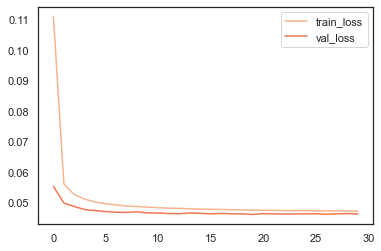

In [45]:
_ = res[['train_loss', 'val_loss']].plot()

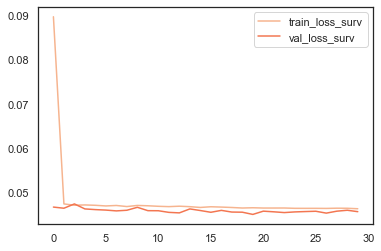

In [46]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

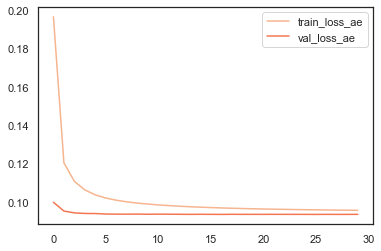

In [47]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

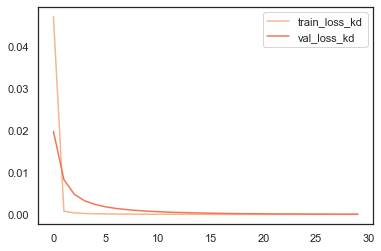

In [48]:
_ = res[['train_loss_kd', 'val_loss_kd']].plot()

In [49]:
surv = model.interpolate(10).predict_surv_df(x_test)

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/torchtuples/base.py:482: UserWarning: The input from the dataloader is different from
                        the 'input' during trainig. The shapes are different.
  warnings.warn(


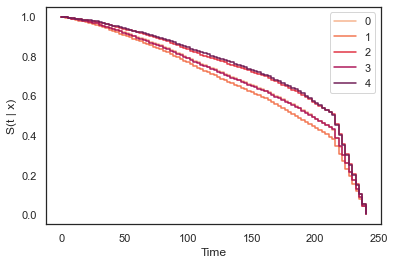

In [50]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [64]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [62]:
print(concordance_td(durations = durations_test, events = events_test, surv = surv.values,
                              surv_idx = idx_at_times(surv.index.values, durations_test, 'post'), method='adj_antolini'))

59.60936079170324


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


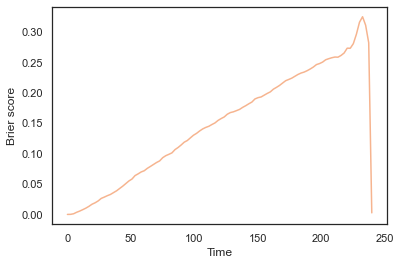

In [65]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

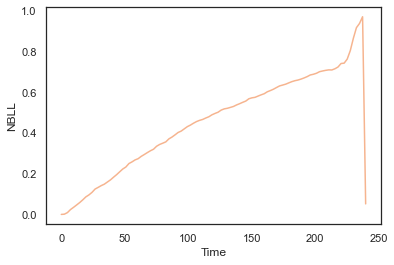

In [66]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [67]:
ev.integrated_brier_score(time_grid) 

0.14880258074003216

In [68]:
ev.integrated_nbll(time_grid) 

0.455624776616014